In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path

In [209]:
datasets_path = str(Path(os.getcwd()).parent) + "/datasets/"
df = pd.read_csv(datasets_path + "down_detector_outage_count.csv")
df_rep = pd.read_csv(datasets_path + "down_detector_reported_problem_count.csv")

In [290]:
# WORKING ONE
def extract_failure_event_times(partial_df):
    start_time = None
    end_time = None
    num_reports_list = []
    failure_events = []
    page_ids = partial_df.sort_values("timestamp")['event_id'].unique()

    q_val = 0.9
    # Extract event_start and event_end from each event
    for page_id in page_ids:
        df_page = partial_df[partial_df["event_id"] == page_id].sort_values("timestamp")
        threshold = df_page["count"].quantile(q_val) 
        while threshold == 0:
            q_val += 0.05
            threshold = df_page["count"].quantile(q_val)
        
        for i, page in df_page.sort_values("timestamp").iterrows():
            nr_reports = page['count']
            event_time = page['timestamp']

            if nr_reports > threshold:
                if start_time == None:
                    start_time = event_time

                num_reports_list.append(nr_reports)

            else:
                if start_time != None:
                    end_time = event_time
                    if 900 * 95 > end_time - start_time > 0: # If duration is longer than 23:45, don't add it.
                        failure_events.append({
                            'start_time': start_time,
                            'end_time': end_time,
                            'duration': end_time-start_time,
                            'peak': np.max(num_reports_list),
                            'threshold': threshold,
                            'median': np.median(num_reports_list),
                            'mean': np.mean(num_reports_list),
                            'page_id': page_id
                        })
                    start_time = None
                    end_time = None
                    num_reports_list = []
                    
    return pd.DataFrame(failure_events)


In [291]:
aws_failures = extract_failure_event_times(df[df["provider"] == "aws"])
gcp_failures = extract_failure_event_times(df[df["provider"] == "gcp"])
azure_failures = extract_failure_event_times(df[df["provider"] == "azure"])

In [292]:
gcp_failures.nunique(), aws_failures.nunique(), azure_failures.nunique()

(start_time    42
 end_time      42
 duration       9
 peak          29
 threshold     11
 median        28
 mean          31
 page_id       13
 dtype: int64,
 start_time    196
 end_time      196
 duration       10
 peak           90
 threshold      52
 median         92
 mean          124
 page_id        69
 dtype: int64,
 start_time    148
 end_time      148
 duration       10
 peak           79
 threshold      44
 median         74
 mean           91
 page_id        50
 dtype: int64)

In [260]:
# NOT WORKING ONE.

def extract_failures_from_reports_V2(partial_df):
    start_time = None
    prev_event_time = None
    num_reports_list = []
    failure_events = []
    
    prev_id = partial_df.sort_values('date')["event_id"].values[0]
    threshold = partial_df[partial_df['event_id'] == prev_id]["count"].quantile(0.85)

    for _, report_event in partial_df.sort_values('date').iterrows():
        nr_reports = report_event['count']
        event_time = report_event['date']
        
        if report_event["event_id"] != prev_id:
            threshold = partial_df[partial_df['event_id'] == report_event["event_id"]]["count"].quantile(0.85)
            prev_id = report_event["event_id"]

        if nr_reports > threshold:
            if start_time == None:
                start_time = event_time
                
            num_reports_list.append({nr_reports: event_time})
            
        elif nr_reports < threshold:
            if start_time != None:
                end_time = event_time
                peak_val = np.max(list(num_reports_list.keys()))
                failure_events.append({
                    'start_time': start_time,
                    'end_time': end_time,
                    'duration': end_time - start_time,
                    'peak': peak_val,
                    'peak_time': num_reports_list[peak_val]
                    'median': np.median(num_reports_list),
                    'mean': np.mean(num_reports_list)
                })
                start_time = None
                num_reports_list = []
    
    return pd.DataFrame(failure_events)

In [261]:
df["date"] = pd.to_datetime(df["timestamp"], unit='s')
df_ex = extract_failures_from_reports_V2(df[df["provider"] == "azure"]).sort_values('duration')

In [262]:
df_ex

,start_time,end_time,duration,peak,median,mean
116,2019-11-19 16:33:35,2019-11-19 16:33:38,00:00:03,11,11.0,11.000000
28,2018-09-04 12:21:51,2018-09-04 12:22:22,00:00:31,394,394.0,394.000000
26,2018-09-04 11:51:51,2018-09-04 11:52:22,00:00:31,214,214.0,214.000000
27,2018-09-04 12:06:51,2018-09-04 12:07:22,00:00:31,306,306.0,306.000000
25,2018-09-04 11:36:51,2018-09-04 11:37:22,00:00:31,241,241.0,241.000000
...,...,...,...,...,...,...
196,2020-10-19 19:07:08,2020-10-19 22:37:08,03:30:00,409,92.0,132.785714
177,2020-08-25 17:23:17,2020-08-25 21:08:17,03:45:00,44,27.0,28.000000
108,2019-10-18 14:05:37,2019-10-18 17:50:37,03:45:00,420,145.0,186.200000
189,2020-09-30 17:33:05,2020-09-30 21:18:05,03:45:00,63,50.0,48.400000


(array([0.07246377, 0.07246377, 0.23188406, 0.23188406, 0.31884058,
        0.31884058, 0.34782609, 0.34782609, 0.46376812, 0.46376812,
        0.55072464, 0.55072464, 0.57971014, 0.57971014, 0.62318841,
        0.62318841, 0.66666667, 0.66666667, 0.68115942, 0.68115942,
        0.69565217, 0.69565217, 0.69565217, 0.69565217, 0.69565217,
        0.69565217, 0.71014493, 0.71014493, 0.72463768, 0.72463768,
        0.73913043, 0.73913043, 0.73913043, 0.73913043, 0.75362319,
        0.75362319, 0.76811594, 0.76811594, 0.7826087 , 0.7826087 ,
        0.79710145, 0.79710145, 0.82608696, 0.82608696, 0.84057971,
        0.84057971, 0.85507246, 0.85507246, 0.86956522, 0.86956522,
        0.86956522, 0.86956522, 0.86956522, 0.86956522, 0.86956522,
        0.88405797, 0.88405797, 0.89855072, 0.89855072, 0.91304348,
        0.91304348, 0.91304348, 0.91304348, 0.92753623, 0.92753623,
        0.92753623, 0.92753623, 0.92753623, 0.92753623, 0.92753623,
        0.92753623, 0.92753623, 0.92753623, 0.92

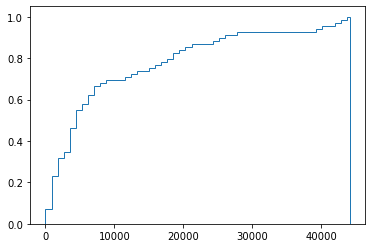

In [107]:
durations = []
for k, v in ev_times.items():
    durations.append(ev_times[k]["duration"])

_, ax = plt.subplots(1, 1)
ax.hist(durations, bins=100, density=True, histtype='step', cumulative=True)

nan nan


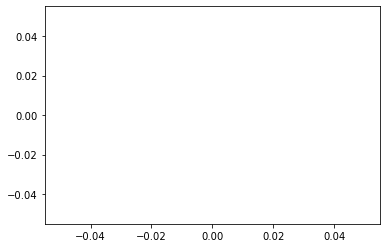

In [307]:
df_aws = df[df["provider"] == "gcp"]
df_ev = df_aws[df_aws["event_id"] == 15]
plt.plot(df_ev["timestamp"], df_ev["count"])
print(df_ev["count"].quantile(.75), df_ev["count"].median())

In [248]:
def extract_failures_from_reports(partial_df):
    event_start = None
    prev_event_time = None
    num_reports_list = []
    failure_events = []
    for _, report_event in partial_df.sort_values('timestamp').iterrows():
        num_reports = report_event['count']
        event_time = report_event['timestamp']

        if num_reports == 0:
            if event_start is not None:
                failure_events.append({
                    'start_time': event_start,
                    'end_time': prev_event_time,
                    'duration': prev_event_time - event_start,
                    'peak': np.max(num_reports_list),
                    'median': np.median(num_reports_list),
                    'mean': np.mean(num_reports_list)
                })
                event_start = None
                num_reports_list = []
        else:
            if event_start is None:
                event_start = event_time
                
            num_reports_list.append(num_reports)

        prev_event_time = event_time
    
    return pd.DataFrame(failure_events)

In [253]:
aws_events = extract_failures_from_reports(df[df["provider"] == "gcp"])
aws_events.sort_values('duration').nunique()

start_time    138
end_time      138
duration       16
peak           21
median         19
mean           29
dtype: int64

In [45]:
df[df["provider"] == "aws"]["count"].median(), df[df["provider"] == "aws"]["count"].quantile(.75)

(2.0, 7.0)

In [46]:
df[df["provider"] == "azure"]["count"].median(), df[df["provider"] == "azure"]["count"].quantile(.75)

(2.0, 7.0)

In [48]:
df[df["provider"] == "gcp"]["count"].mean(), df[df["provider"] == "gcp"]["count"].quantile(.8)

(8.45344129554656, 3.0)

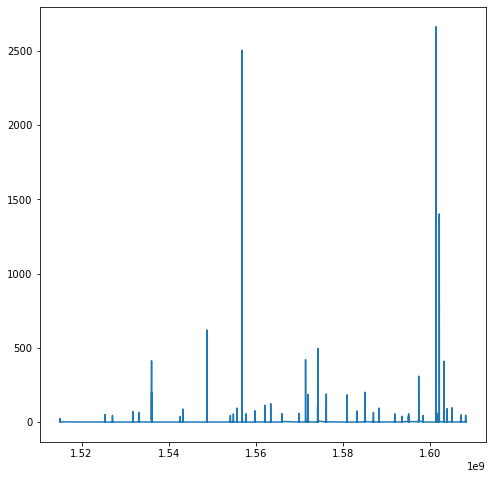

In [139]:
# Checking events
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
df_aws = df[df["provider"] == "azure"]
for i in range(1):
    ax.plot(df_aws["timestamp"], df_aws["count"])